<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/400_training_samples_W207_Breast_Cancer_IDC_Prediction_Using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
**Heesuk Jang**
 

#Predicting IDC (Invasive Ductal Carcinoma 침윤성 유관암) with Breast Histopathology (조직병리학) Images using a CNN

- Need to perform data augmentations on train/test/validation data sets


In [1]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
# from tensorflow.keras.layers import Conv2D
# from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [2]:
%pwd

'/content'

## Unzip the Dataset zip from Google Drive

In [3]:
!unzip gdrive/MyDrive/Kaggle/Dataset.zip

Archive:  gdrive/MyDrive/Kaggle/Dataset.zip
   creating: Dataset/
   creating: Dataset/Validate/
  inflating: Dataset/.DS_Store       
  inflating: __MACOSX/Dataset/._.DS_Store  
   creating: Dataset/Test/
   creating: Dataset/Train/
  inflating: Dataset/Validate/.DS_Store  
  inflating: __MACOSX/Dataset/Validate/._.DS_Store  
   creating: Dataset/Validate/0/
   creating: Dataset/Validate/1/
  inflating: Dataset/Test/.DS_Store  
  inflating: __MACOSX/Dataset/Test/._.DS_Store  
   creating: Dataset/Test/0/
   creating: Dataset/Test/1/
  inflating: Dataset/Train/.DS_Store  
  inflating: __MACOSX/Dataset/Train/._.DS_Store  
   creating: Dataset/Train/0/
   creating: Dataset/Train/1/
  inflating: Dataset/Validate/0/12867_idx5_x651_y1801_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._12867_idx5_x651_y1801_class0.png  
  inflating: Dataset/Validate/0/16165_idx5_x3001_y1551_class0.png  
  inflating: __MACOSX/Dataset/Validate/0/._16165_idx5_x3001_y1551_class0.png  
  inflating: Datase

## Read the first 200 train images from each class stored in the Dataset folder 
- **Class 0 (Non-IDC)**
- **Class 1 (IDC)**

In [4]:
# Correct for data imbalance by sampling equal size of images from each class
def read_train_images(binary_class, folder):
  current_working_dir = os.getcwd()
  # train_folder, test_folder, val_folder = 'Dataset/Train/', 'Dataset/Test/', 'Dataset/Validate/'

  image_files_w_path, image_files_wo_path = [], []
  for img in glob.glob(os.path.join(current_working_dir, folder + binary_class + '/') + '*.png'):
    image_files_w_path.append(img)
    image_wo_path = os.path.basename(img)
    image_files_wo_path.append(image_wo_path)   
  # print(len(image_files_wo_path)) 
  return image_files_wo_path[:200], image_files_w_path[:200]    # pull the first 200 images from the random training samples of 800

train_class_1_wo_path, train_class_1_w_path = read_train_images('1', 'Dataset/Train/')
train_class_0_wo_path, train_class_0_w_path = read_train_images('0', 'Dataset/Train/')
train_full_wo_path = train_class_1_wo_path + train_class_0_wo_path
train_full_w_path = train_class_1_w_path + train_class_0_w_path

print(f'Size of Class 1 = {len(train_class_1_wo_path)} | {type(train_class_1_wo_path)}\nSample Images in Class 1:\n {train_class_1_wo_path[:2]}')
print(f'\nSize of Class 0 = {len(train_class_0_wo_path)} | {type(train_class_0_wo_path)}\nSample Images in Class 0:\n {train_class_0_wo_path[:2]}')
print('\nclass_1 and class_0 combined:\n',train_full_wo_path[0], ',', train_full_wo_path[-1])
print('\nclass_1 with full path:\n',train_class_1_w_path[:2])

Size of Class 1 = 200 | <class 'list'>
Sample Images in Class 1:
 ['8864_idx5_x1801_y2151_class1.png', '12934_idx5_x1951_y901_class1.png']

Size of Class 0 = 200 | <class 'list'>
Sample Images in Class 0:
 ['10308_idx5_x751_y1951_class0.png', '13106_idx5_x351_y1901_class0.png']

class_1 and class_0 combined:
 8864_idx5_x1801_y2151_class1.png , 10304_idx5_x1901_y1451_class0.png

class_1 with full path:
 ['/content/Dataset/Train/1/8864_idx5_x1801_y2151_class1.png', '/content/Dataset/Train/1/12934_idx5_x1951_y901_class1.png']


## Check the number of image files in each class


In [5]:
def check_class_size(class_1, class_0):
  class_1_size, class_0_size = len(class_1), len(class_0)
  count = pd.Series([class_1_size, class_0_size])
  percent = round(count/(class_1_size + class_0_size)*100, 2)
  df_perc = pd.concat({'class_count':count, 'class_percent(%)':percent}, axis=1)
  df_perc['class'] = ['Class 1 (Malignant)', 'Class 0 (Benign)']
  df_perc = df_perc[['class','class_count','class_percent(%)']]
  print('Total Count (Balanced) = ', class_1_size + class_0_size)
  return df_perc

check_class_size(train_class_1_wo_path, train_class_0_wo_path)

Total Count (Balanced) =  400


,class,class_count,class_percent(%)
0,Class 1 (Malignant),200,50.0
1,Class 0 (Benign),200,50.0


## Create dataframes for each class

In [6]:
def create_class_df(): 
  image_list_w_path = [x for x in train_class_1_w_path]
  image_list_w_path.extend([x for x in train_class_0_w_path])
  df_idc= pd.DataFrame(np.concatenate([['IDC']*len(train_class_1_w_path), ['Non_IDC']*len(train_class_0_w_path)]), columns=['class_str'])
  df_idc['class'] = np.where(df_idc.class_str == 'IDC', 1, 0)
  df_idc['image'] = [x for x in image_list_w_path]
  print('Shape: ', df_idc.shape)
  return df_idc

df_full = create_class_df()
df_full

Shape:  (400, 3)


,class_str,class,image
0,IDC,1,/content/Dataset/Train/1/8864_idx5_x1801_y2151...
1,IDC,1,/content/Dataset/Train/1/12934_idx5_x1951_y901...
2,IDC,1,/content/Dataset/Train/1/15902_idx5_x2201_y140...
3,IDC,1,/content/Dataset/Train/1/13025_idx5_x2101_y100...
4,IDC,1,/content/Dataset/Train/1/14213_idx5_x1701_y130...
...,...,...,...
395,Non_IDC,0,/content/Dataset/Train/0/9181_idx5_x951_y851_c...
396,Non_IDC,0,/content/Dataset/Train/0/9255_idx5_x1901_y801_...
397,Non_IDC,0,/content/Dataset/Train/0/13021_idx5_x1501_y551...
398,Non_IDC,0,/content/Dataset/Train/0/12905_idx5_x1951_y120...


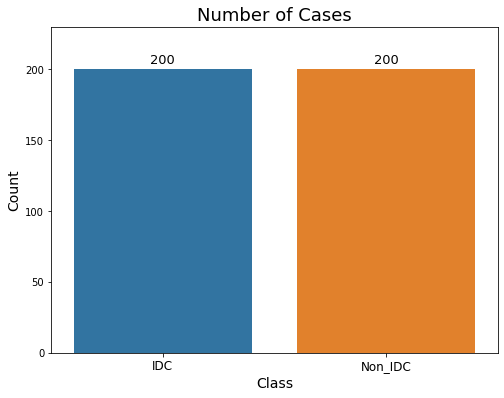

In [7]:
plt.figure(figsize=(8,6))
ax = sns.countplot(df_full['class_str'], data=df_full)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.title('Number of Cases', fontsize=18)
plt.ylim(0,230)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
               (p.get_x() + p.get_width()/2., 
                p.get_height()), ha='center', va='center', size=15, xytext=(0,9),
               textcoords = 'offset points', fontsize=13)

# 1. Binary Classification 
: IDC vs Non-IDC



## Display 6 images for each class
: 512 (width) by 512 (height) array of pixel values per image

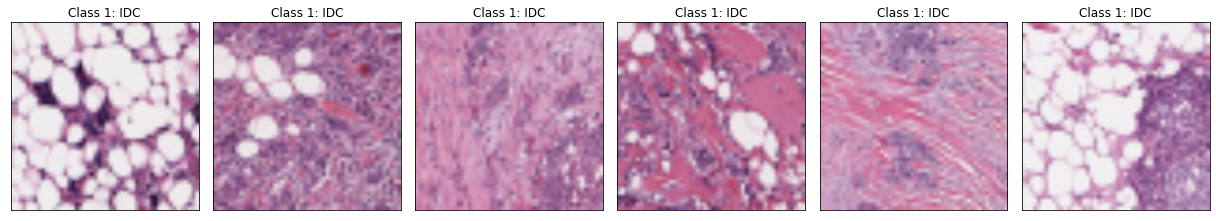

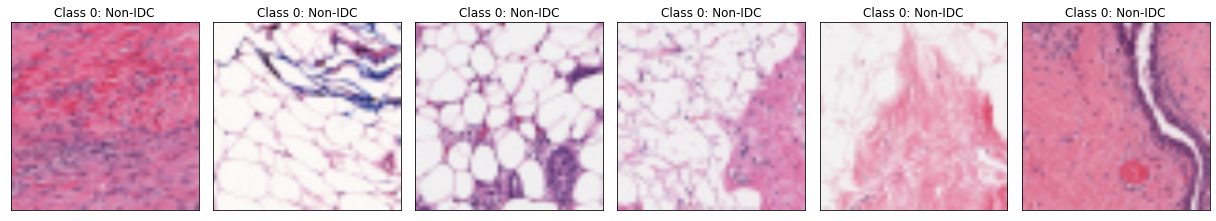

In [8]:
def display_images(subclass, class_name):
  fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,6))
  # images = []
  for idx, ax in enumerate(axes.flat):
    img = io.imread(subclass[idx])
    img = cv.resize(img, (512,512))    # resize an image from 50 by 50 to 512 by 512
    ax.imshow(img)
    ax.set_title(class_name)
    ax.set_xticks([])       # remove xticks passing an empty array
    ax.set_yticks([])       # remove yticks passing an empty array
  fig.tight_layout() 
  plt.show() 

display_images(train_class_1_w_path, 'Class 1: IDC')
display_images(train_class_0_w_path, 'Class 0: Non-IDC')

## Store actual images in grayscale as a vector
: The **color.rgb2gray()** takes an image in RGB format as input and returns a grayscale copy of the input image. 

In [14]:
from skimage import color
# read and store actual images (not the image paths) into the respective variable as a single vector then pass these to the model below
image_pixels_class1 = [io.imread(img, as_gray=True) for img in train_class_1_w_path]
image_pixels_class0 = [io.imread(img, as_gray=True) for img in train_class_0_w_path]
full_image_pixels = np.asarray(image_pixels_class1 + image_pixels_class1)


print('Shape of each raw image: ', image_pixels_class1[0].shape)
print('\nTotal number of images = ', len(image_pixels_class1 + image_pixels_class0))
print('Number of class 1 images = ', len(image_pixels_class1))
print('Number of class 0 images = ', len(image_pixels_class0))
print('full_image_pixels = ', full_image_pixels.shape)
print('full_image_pixels[0] = ', full_image_pixels[0].shape)

Shape of each raw image:  (50, 50)

Total number of images =  400
Number of class 1 images =  200
Number of class 0 images =  200
full_image_pixels =  (400, 50, 50)
full_image_pixels[0] =  (50, 50)


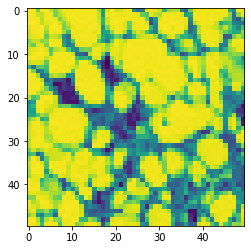

In [15]:
# Display a grayscale image
# plt.figure(figsize=(5,5))
plt.imshow(image_pixels_class1[0])

Shape of each image:  (50, 50)


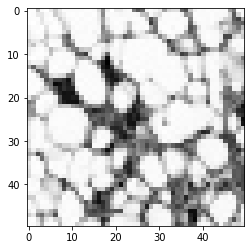

In [16]:
from skimage.color import rgb2gray
print('Shape of each image: ', io.imread(train_class_1_w_path[0], as_gray=True).shape)
# plt.figure(figsize=(5,5))
plt.imshow(rgb2gray(io.imread(train_class_1_w_path[0])), 'gray')   # display as gray

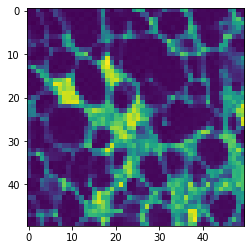

In [17]:
# Invert an image
from skimage import util

inverted_img = util.invert(image_pixels_class1[0])
# plt.figure(figsize=(5,5))
plt.imshow(inverted_img)

## Specify image data (X) and labels (y)

In [13]:
X = full_image_pixels
y = np.array(df_full['class']).flatten()
print('y: total number of images = ', len(y), type(y) ,'\n', y[:5], y[-5:])
print('\nX: total number of images = ', len(X), type(X), '\n', X[0])

y: total number of images =  400 <class 'numpy.ndarray'> 
 [1 1 1 1 1] [0 0 0 0 0]

X: total number of images =  400 <class 'numpy.ndarray'> 
 [[0.93331059 0.93357843 0.75311725 ... 0.47895333 0.93221725 0.92013922]
 [0.93808824 0.92997725 0.86435843 ... 0.38455216 0.79882275 0.92351804]
 [0.93192667 0.93473216 0.93528275 ... 0.39156196 0.30258784 0.65569608]
 ...
 [0.78167725 0.85486353 0.53290549 ... 0.66545098 0.68532667 0.92269961]
 [0.93162118 0.94089373 0.83460706 ... 0.34181059 0.65616353 0.90722078]
 [0.93333333 0.92940392 0.87836314 ... 0.80746941 0.77917725 0.86744667]]


## Randomize images (X) and labels (y) 


In [19]:
#  randomize image data
# (X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = full_image_pixels
import numpy as np
np.random.seed(0)
shuffled_y = shuffle(y)
print(len(y), '\n', shuffled_y[:10])
shuffled_X = shuffle(X)
print('\n',len(X), '\n', shuffled_X[0])

400 
 [1 0 0 1 0 1 1 0 1 0]

 400 
 [[0.64345176 0.61067255 0.62073294 ... 0.85596471 0.89467529 0.60112157]
 [0.61457922 0.60902863 0.60504667 ... 0.66474902 0.88847608 0.79772941]
 [0.56925451 0.56706    0.58687529 ... 0.56772    0.74746078 0.90026353]
 ...
 [0.41520431 0.32170471 0.5318902  ... 0.48834941 0.57105333 0.57095529]
 [0.61906627 0.51569098 0.58787843 ... 0.55756157 0.57226745 0.58448471]
 [0.59189804 0.39762118 0.51180706 ... 0.60585725 0.42562275 0.53800627]]


## Train/Test Split (80/20)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_y, test_size=0.2, random_state=42)

# X_train = X_train / 255
# X_test = X_test / 255
print('X_train.shape: ',X_train.shape, ' | Each input image shape: ', X_train[0].shape)
print('X_test.shape: ',X_test.shape, ' | Each input image shape: ', X_test[0].shape)
print('\ny_train.shape: ',y_train.shape, '=> 10 sample data: ', y_train[-10:] )
print('y_test.shape: ',y_test.shape, '=> 10 sample data: ', y_test[-10:] )
print('\nOne image 3D pixels in X_test):\n', X_test[0])

X_train.shape:  (320, 50, 50)  | Each input image shape:  (50, 50)
X_test.shape:  (80, 50, 50)  | Each input image shape:  (50, 50)

y_train.shape:  (320,) => 10 sample data:  [0 0 1 1 0 0 1 0 0 0]
y_test.shape:  (80,) => 10 sample data:  [1 1 1 1 0 1 0 1 1 0]

One image 3D pixels in X_test):
 [[0.79055333 0.81834745 0.88674902 ... 0.79588863 0.78721216 0.73285294]
 [0.73978745 0.80038353 0.76956157 ... 0.723      0.64598235 0.70697059]
 [0.71183843 0.68480235 0.65916863 ... 0.76777412 0.66474196 0.72120549]
 ...
 [0.70130706 0.68950471 0.70270588 ... 0.66583529 0.69044314 0.73186902]
 [0.7257451  0.69457216 0.64539412 ... 0.69652941 0.70833176 0.69737765]
 [0.72095255 0.75629216 0.68925176 ... 0.71589216 0.67856549 0.72938392]]


In [ ]:
# xtrain_idx = list(range(0, X_train.shape[0], 50000))
# xtrain_idx.extend([X_train.shape[0]])
# print(type(xtrain_idx), xtrain_idx)

# step_size = 10000
# xtest_idx = list(range(0, X_test.shape[0]-step_size, step_size))
# last_idx = X_test.shape[0] - xtest_idx[-1]
# # xtest_idx.extend([X_test.shape[0]])
# print(type(xtest_idx), xtest_idx)
# print('last_idx: ',last_idx)

## Normalize X_train image pixels

In [ ]:
step = 10000
xtrain_idx = list(range(0, X_train.shape[0] - step, step))
initial_array = np.array([])
initial_array = np.concatenate([X_train[idx:idx + step]/255 for idx in xtrain_idx])
print('initial_array.shape: ',initial_array.shape)
# print(X_train[xtrain_idx[-1] + step, X_train.shape[0])
# last_batch_norm = X_train[xtrain_idx[-1] + step:X_train.shape[0]]/255
# X_train_norm = np.concatenate([initial_array, last_batch_norm])
# print('X_train_norm.shape: ',X_train_norm.shape, '\n', X_train_norm[0])

initial_array.shape:  (220000,)


## Normalize X_test image pixels

In [ ]:
step = 10000
xtest_idx = list(range(0, X_test.shape[0] - step, step))
initial_array = np.array([])
initial_array = np.concatenate([X_test[idx:idx + step]/255 for idx in xtest_idx])
print('initial_array.shape: ',initial_array.shape)

last_batch_norm = X_test[xtest_idx[-1] + step:X_test.shape[0]]/255
X_test_norm = np.concatenate([initial_array, last_batch_norm])
print('X_test_norm.shape: ',X_test_norm.shape, '\n', X_test_norm[0])

initial_array.shape:  (50000,)
X_test_norm.shape:  (55505,) 
 [[0.00255791 0.00251619 0.00213805 ... 0.00185951 0.00207439 0.00188774]
 [0.00240839 0.00292526 0.00269986 ... 0.00215626 0.00203411 0.00257922]
 [0.00235148 0.00173282 0.00246116 ... 0.00246282 0.00266598 0.00224521]
 ...
 [0.00208    0.00262063 0.00236295 ... 0.00241615 0.00249655 0.0024395 ]
 [0.00188989 0.00218053 0.00240947 ... 0.0022581  0.00231976 0.00206708]
 [0.00268655 0.00240707 0.00268541 ... 0.00243033 0.00232037 0.00219635]]


In [ ]:
# # X_train_norm_1 = X_train[:100000] / 255
# X_train_norm_2 = X_train[100000:110000] / 255
# X_train_norm_3 = X_train[105000:110000] / 255
# X_train_norm_4 = X_train[110000:115000] / 255
# X_train_norm_5 = X_train[115000:120000] / 255
# X_train_norm_6 = X_train[120000:125000] / 255
# X_train_norm_7 = X_train[125000:130000] / 255
# print(X_train_norm_2[0])

## Set 20% of validation data out of training dataset
We don't want to just optimize our model and its hyperparameters for just these train and test data sets. There is a chance that the model will perform badly on unseen data because it hasn't really had the chance to test itself against one. 

To mitigate this, we'll take 20% of our training data and put it into validation data. We'll be optimizing our model on these two before introducing it to our test dataset.

In [ ]:
'''
set random_state for repeatability and stratify to make the function understand 
that the portion we split from original df must contain the same proportion of elements as in the original df. 
i.e. suppose for every 10 observations you have 7 IDC and 3 non-IDC in the training dataset. we want the same proportion in the validataion as well.
'''
# train_df, val_df = train_test_split(train, test_size=0.2, random_state=13, stratify=train['class'])

'\nset random_state for repeatability and stratify to make the function understand \nthat the portion we split from original df must contain the same proportion of elements as in the original df. \ni.e. suppose for every 10 observations you have 7 IDC and 3 non-IDC in the training dataset. we want the same proportion in the validataion as well.\n'

## Preprocessing (Normalization)
Normalization helps our algorithm train better. The reason why we typically want normalized pixel values is becasue **neural networks rely on gradient calculations.** These networks are trying to learn how important or how weighty a certain pixel should be in determining the class of an image. Normalizing pixel values help these gradient calculations stay consistent and not get so large that they slow don or prevent network from training. In a typical grayscale image, the pixel values will range from 0-255. we will be using **ImageDataGenerator** to preprocess our data.

In [ ]:
# from keras_preprocessing.image import image_data_generator
# # ImageDataGenerator allows the users to perform image augmentation but here we will repurpose it to just normalize our images
# # Rescale all the pixel valuesin our images to a value in the range of 0 to 1.
# from keras.preprocessing.image import ImageDataGenerator

# image_generator = ImageDataGenerator(rescale=1/255)
# # val_norm = ImageDataGenerator(rescale=1/255)

# # train_norm_vector = np.reshape(train_norm, (67500,))

In [ ]:
# generator = image_generator.flow_from_dataframe(
#       X_train,
#       x_col='image',
#       y_col='class',
#       targt_size=(150,150),   # larger images increasing training time with no substantial benefit so resize to smaller scale
#       batch_size=32,
#       class_mode='binary',    # two classes (IDC vs Non-IDC)
#       shuffle=binary,
#       seed=7
#   )

## Feed nomalized train, validataion, and test images to CNN
We need a way to read and then feed to our CNN all those rescaled images from our dataframes and that is where the method flow_from_dataframe comes in.
- **targt_size=(150,150):** can increase or decrease this according to your computational resources.
- **batch_size:** defines the number of samples that we've propagated through the network, basically, number of images per batch that is fed into the CNN. This value typically ranges from 16 - 512. Large batch sizes require more computational power so we here have set this to 32.


In [ ]:
# def generate_input_images_to_feed_cnn(df_norm, df, binary):
#   '''flow_from_dataframe() generates batches of input iamges that can be used as the input to our network'''  
#   generator = df_norm.flow_from_dataframe(
#       df,
#       x_col='image',
#       y_col='class',
#       targt_size=(150,150),   # larger images increasing training time with no substantial benefit so resize to smaller scale
#       batch_size=32,
#       class_mode='binary',    # two classes (IDC vs Non-IDC)
#       shuffle=binary,
#       seed=7
#   )
#   return generator

# train_generator = generate_input_images_to_feed_cnn(train_norm, train_df, 'True')
# val_generator = generate_input_images_to_feed_cnn(val_norm, val_df, 'True')

# # shuffle to False on the test_generator since we don't want ImageDataGenerator to be shuffling the test,which it does so by default
# test_generator = generate_input_images_to_feed_cnn(val_norm, test, 'False') 

# train_generator

## Feature Extraction
The layout of a CNN can be broadly divided into feature extraction and classification.
- **Convolutions:**<br>
    1) Input image<br>
    2) Filter<br>
    3) Feature maps<br>
- **Activation:**<br>
    1) Sigmoid<br>
    2) Tanh<br>
    3) ReLU<br>
    2) Leaky ReLU<br>
- **Pooling:**<br>
    1) Max pooling<br>

## Classification
For classification, the output of the previous layer, that is, the last layer in **feature extraction** becomes the input to what is called the **fully connected layer**. The fully connected layer outputs an undimensional vector where N is the **number of classes**. For example, in a cat or dog problem, N=2. And in a digit classification where the network is supposed to say which digit it is from 0 to 9, N=10. Each number of the N-dimensional vector contains the probability of that particular class, and the class with the highest probability is chosen.

## Model Architecture
Every one of the following parameters can be changed and experimented with to see how it affects the network and its performance, and these things are called **hyperparameters**.
- **filters:** the number of filters we want. let's start with 16
- **kernel_size:** = filter size. A filter is also called **kernel**. Set it to (3,3) = (width, height)
- **activation:** will go with **ReLu**
- **input_shape:** the input dimensions of the image. This will be the same as what we told the ImageDataGenerator. We also have a **depth of 3** since these are color images. The input_shape param is only needed in the 1st convolutional layer.

**Conv2D = 2D convolution layer**. This layer creates a convolution kernel (= filter) that is convolved with the layer input to produce a tensor of outputs. The **number of layers** in a CNN also affects the network performance and is something that'll need to be played around with. For preparing data to be fed into a **fully connected layer**, we need to **flatten** the dataset. And then we'll pass the info to a fully connected layer. We'll be using two fully connected layers here. **Dense** indicates that it is indeed a fully connected layer.

For the **1st Dense layer**, we specify the **number of units or neurons**. Since this is a binary classification problem, we will have 1 neuron or 1 unit for the **final Dense layer**. If it was a **multi-class classification** problem, you will have as many units as there are classes. For the activation function, we will use **Sigmoid**, which we input the value of the last layer and we get a value in the range of 0 to 1. If the value is greater than the threshold value let's say 0.5, we consider the model output as one class or the other class of the value is less than the threshold value.  

Now we created the first CNN network! Now we need to **compile** it. This is where we specify the **configurations of the training process**. First we need to specify a **loss function**. The objective of the model will be **to minimize the loss function**. Since this is a binary classification problem, we will use **binary_crossentropy**. Then we'll specify what type of optimizer the model uses to do this. Optimizers are algorithms or methods, used to change the attributes of a neural network such as **weights and learning rate** in order **to reduce the losses**. They are many types of optimizers. We'll use the **adam optimizer**, which is arguably the most popular. Finally we'll also provide a **metric** for us to see how well the model is doing. Since this is a classification problem, **accuracy** whould work well. To get an overview of the model and the number of params that are in play, you can use **model.summary**.

## Build the first CNN model - Feature Extraction

In [ ]:
# Importing the necessary packages
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential

In [ ]:
def build_model():
  # Building the CNN
  model = Sequential()      # initialize the model using Sequential(), which indicates our network will be stacked with different layers

  # Add the convolutional layers
  model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))  # 1st convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 1st Pooling
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))                           # 2nd convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 2nd Pooling
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))                           # 3rd convolutional layer
  model.add(MaxPooling2D(pool_size=(2,2)))                                                   # 3rd Pooling

  # Flatten the dataset to feed into a fully connected layer
  model.add(Flatten())    # may not need it since I flatten the data prior

  # Fully connected layer
  model.add(Dense(64, activation='relu'))    # For the first layer: 64 = the number of units or neurons
  model.add(Dense(1, activation='sigmoid'))  # For the final layer

  # optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)   # Use the SGD optimizer 

  #  Compiling
  model.compile(loss='binary_crossentropy',
                optimizer='adam',                    # use SGD instead?: optimizer=optimizer
                metrics=['accuracy'])            # metrics=[metrics.binary_accuracy])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

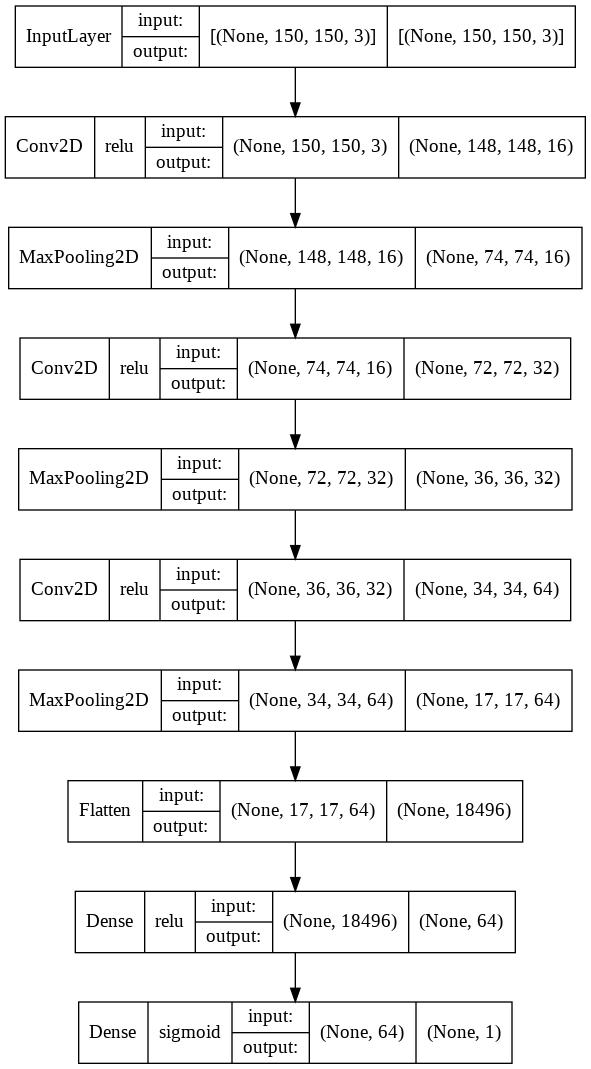

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

## Training the Model

In [ ]:
# There are many other args other th
# an the followin three that you can include here but right now, we're trying to build a minimum viable network.
# from tensorflow import keras
model_1 = model.fit(train_generator, epochs=10, validation_data=val_generator)     # Hyperparam which we can play around: one epoch includes the forward propagation and back propagation

model_1 = pd.DataFrame(model_1.history)
display(model_1)

NameError: ignored

In [ ]:
plt.figure(figsize=(12,8))

# Plot the loss function for training and validation datasets
plt.subplot(2,2,1)
plt.plot(model_1.history['loss'], label='Training Loss')
plt.plot(model_1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss - Training vs Validation Dataset')

# Plot the loss function for training and validation datasets
plt.subplot(2,2,2)
plt.plot(model_1.history['accuracy'], label='Training accuracy')
plt.plot(model_1.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy - Training vs Validation Dataset')

# 2. Prediction 
: predict the most common area that may be detected IDC


## Extract features from file names

In [ ]:
def extract_features(file_list): 
  features = []
  for file in file_list:
    str_feat = re.findall(r'\d+', file)
    int_feat = [int(feat) for feat in str_feat]
    features.append(int_feat)
  df_feat = pd.DataFrame(features, columns=['patient_id', 'd', 'x_coord', 'y_coord', 'class']).drop('d', axis=1)
  df_feat['patch_coord'] = list(zip(df_feat.x_coord, df_feat.y_coord))
  return df_feat[['patient_id','x_coord', 'y_coord', 'patch_coord','class']]

df_features = extract_features(full_data_wo_path)
print(df_features.shape)
display(df_features.head().append(df_features.tail()))

(277524, 5)


,patient_id,x_coord,y_coord,patch_coord,class
0,12884,1701,601,"(1701, 601)",1
1,12884,1501,951,"(1501, 951)",1
2,12884,1701,1001,"(1701, 1001)",1
3,12884,1651,751,"(1651, 751)",1
4,12884,1201,701,"(1201, 701)",1
277519,9347,1201,501,"(1201, 501)",0
277520,9347,651,1,"(651, 1)",0
277521,9347,1901,1201,"(1901, 1201)",0
277522,9347,901,451,"(901, 451)",0
277523,9347,901,151,"(901, 151)",0


In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   patient_id   277524 non-null  int64 
 1   x_coord      277524 non-null  int64 
 2   y_coord      277524 non-null  int64 
 3   patch_coord  277524 non-null  object
 4   class        277524 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 10.6+ MB


## Randomize data 
: As we may use SGD for training, we will randomize sample of the data for each batch so that the gradient computed is representative.

In [ ]:
indexes = np.arange(df_features.shape[0])
print('indexes:', indexes)

np.random.seed(0)    # get the same results each time    ??????
shuffled_indexes = np.random.permutation(indexes)
print('shuffled indexes:', shuffled_indexes, '\n')

# change the ordering of the original df_features using .reindex()
df_features = df_features.reindex(shuffled_indexes)
display(df_features)

indexes: [     0      1      2 ... 277521 277522 277523]
shuffled indexes: [106139   3019  55132 ... 122579 152315 117952] 



,patient_id,x_coord,y_coord,patch_coord,class
106139,16551,1801,2451,"(1801, 2451)",0
3019,12881,351,1401,"(351, 1401)",1
55132,15514,651,1501,"(651, 1501)",1
29918,13024,1001,1551,"(1001, 1551)",1
25418,9259,1101,2151,"(1101, 2151)",1
...,...,...,...,...,...
211543,9176,851,1901,"(851, 1901)",0
86293,9041,2151,1551,"(2151, 1551)",0
122579,8955,951,1601,"(951, 1601)",0
152315,13693,1351,1751,"(1351, 1751)",0


## Train/Test split (80/20) & Feature Selection

In [ ]:
split_boundary = int(df_features.shape[0]*.8)

train = pd.DataFrame(df_features.iloc[:split_boundary, 3:])
test = pd.DataFrame(df_features.iloc[split_boundary:, 3:])

print('Train Shape: ', train.shape, '\n', train.head(3))
print('\nTest Shape: ', test.shape, '\n', test.head(3))

Train Shape:  (222019, 2) 
          patch_coord  class
106139  (1801, 2451)      0
3019     (351, 1401)      1
55132    (651, 1501)      1

Test Shape:  (55505, 2) 
         patch_coord  class
201175   (701, 951)      0
54014   (1751, 851)      1
84344   (2501, 401)      0
